In [1]:
!pip install pandas h5py matplotlib scikit-learn

# GravitySpy Challenge

## Get the dataset

Save it to your drive after downloading it :)
Files -> Mount Drive -> Drag and drop

File Path is: 'drive/My Drive/...'

In [2]:
!wget "https://zenodo.org/records/1476156/files/trainingset_v1d0_metadata.csv"

--2024-02-21 09:30:03--  https://zenodo.org/records/1476156/files/trainingset_v1d0_metadata.csv
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248944 (243K) [text/plain]
Saving to: ‘trainingset_v1d0_metadata.csv’

trainingset_v1d0_me 100%[===================>] 243.11K   293KB/s    in 0.8s    

2024-02-21 09:30:05 (293 KB/s) - ‘trainingset_v1d0_metadata.csv’ saved [248944/248944]



In [3]:
!wget "https://zenodo.org/records/1476156/files/trainingsetv1d0.h5"

--2024-02-21 09:30:07--  https://zenodo.org/records/1476156/files/trainingsetv1d0.h5
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.184.103.159, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3287645752 (3.1G) [application/octet-stream]
Saving to: ‘trainingsetv1d0.h5’

trainingsetv1d0.h5  100%[===================>]   3.06G  14.3MB/s    in 3m 51s  

2024-02-21 09:33:59 (13.6 MB/s) - ‘trainingsetv1d0.h5’ saved [3287645752/3287645752]



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

In [7]:
# Open the meta table, holds info images and labels
meta = pd.read_csv('drive/My Drive/trainingset_v1d0_metadata.csv')
meta

,gravityspy_id,label,sample_type
0,09HE6k6EaS,1080Lines,train
1,0Lojrrjlme,1080Lines,test
2,0OQg3uD6tp,1080Lines,test
3,0jdZllcAme,1080Lines,validation
4,0pS2TZ7ssW,1080Lines,train
...,...,...,...
8578,yyjqLCtAmO,Whistle,validation
8579,zKCTakFVcf,Whistle,train
8580,zWFRqqDxwv,Whistle,test
8581,zmIdpucyOG,Whistle,train


In [8]:
meta['label'].unique()

array(['1080Lines', '1400Ripples', 'Air_Compressor', 'Blip', 'Chirp',
       'Extremely_Loud', 'Helix', 'Koi_Fish', 'Light_Modulation',
       'Low_Frequency_Burst', 'Low_Frequency_Lines', 'No_Glitch',
       'None_of_the_Above', 'Paired_Doves', 'Power_Line',
       'Repeating_Blips', 'Scattered_Light', 'Scratchy', 'Tomte',
       'Violin_Mode', 'Wandering_Line', 'Whistle'], dtype=object)

In [9]:
import h5py
import numpy as np

In [10]:
# open data
data = h5py.File('drive/My Drive/trainingsetv1d0.h5')

In [11]:
def get_data_by_idx(idx, meta, data):
    id, label, sample_type = meta.iloc[idx]
    stack = []
    for _, ch in data[label][sample_type][id].items():
        stack.append(ch)
    stack = np.concatenate(stack)
    return stack, label

Channels are: 0.5, 1, 2, 4 second time windows

In [12]:
sample, sample_label = get_data_by_idx(0, meta, data)

In [13]:
sample_label

'1080Lines'

In [14]:
import matplotlib.pyplot as plt

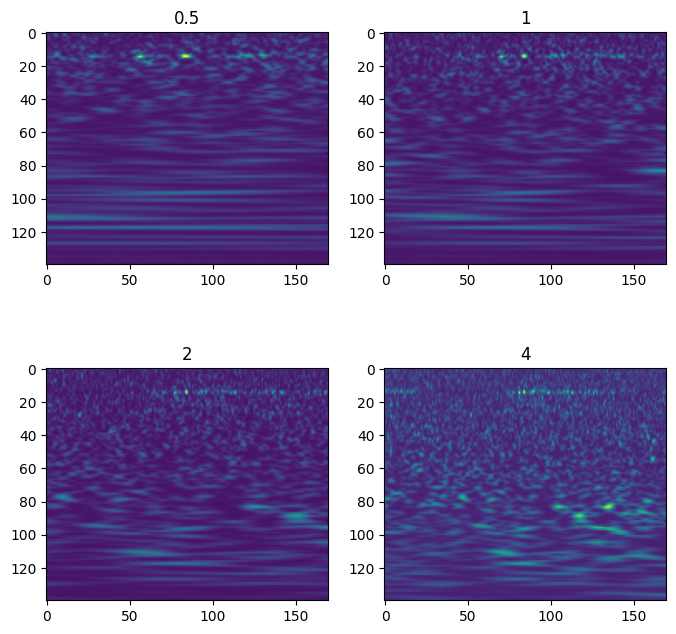

In [15]:
fig, axs = plt.subplots(2,2, figsize=(8,8))

for ch_idx, (ax, ch_name) in enumerate(zip(axs.flatten(), [0.5, 1, 2, 4])):
    ax.imshow(sample[ch_idx])
    ax.set_title(f'{ch_name}')

Split in train, test, valid!

In [16]:
def get_data_random_by_type(type, meta, data):
    idx = np.random.choice(range(np.sum(meta['sample_type']==type)))
    id, label, sample_type = meta[meta['sample_type']==type].iloc[idx]
    stack = []
    for _, ch in data[label][sample_type][id].items():
        stack.append(ch)
    stack = np.concatenate(stack)
    return stack, label

In [17]:
sample, label = get_data_random_by_type('train', meta, data)
label

'Power_Line'

In [18]:
sample, label = get_data_random_by_type('test', meta, data)
label

'Koi_Fish'

In [19]:
sample, label = get_data_random_by_type('validation', meta, data)
label

'Blip'

In [20]:
def get_data_random_by_label_and_type(label, type, meta, data):
    selection_mask = (meta['sample_type']==type) & (meta['label']==label)
    idx = np.random.choice(range(np.sum(selection_mask)))
    id, label, sample_type = meta[meta['sample_type']==type].iloc[idx]
    stack = []
    for _, ch in data[label][sample_type][id].items():
        stack.append(ch)
    stack = np.concatenate(stack)
    return stack, label

In [21]:
sample, label = get_data_random_by_label_and_type('1080Lines', 'train', meta, data)
label

'1080Lines'

In [27]:
# Helper for plotting images
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_samples(samples, labels, ch=0, ncols=4):
    n = len(samples)
    nrows = -(-n // ncols)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 5), layout='constrained')

    for s, label, ax in zip(samples, labels, axs.ravel()):
        ax.imshow(s[ch])
        ax.set_title(label)
        ax.axis('off')

LABEL_NAMES = meta['label'].unique()

def show_confusion(true_labels, predicted_labels, normalize=None):
  fig, axs = plt.subplots(figsize=(9, 9))
  ConfusionMatrixDisplay(
      confusion_matrix(
        y_true=true_labels,
        y_pred=predicted_labels,
        labels=np.arange(len(LABEL_NAMES)),
        normalize=normalize
      ),
      display_labels=LABEL_NAMES,
  ).plot(ax=axs, xticks_rotation="vertical")

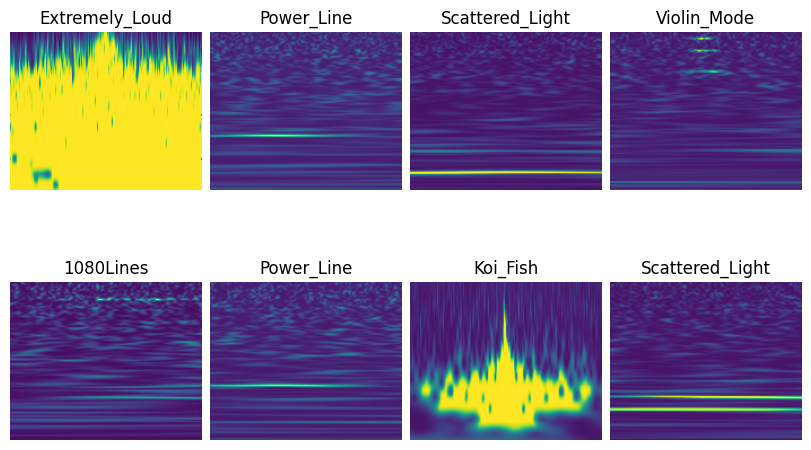

In [28]:
samples, labels = zip(*[get_data_random_by_type('train', meta, data) for i in range(8)])
show_samples(samples, labels)

In [29]:
LABEL_IDX_DICT = dict(zip(meta['label'].unique(), np.arange(len(meta['label'].unique()))))

In [30]:
label_indices = [LABEL_IDX_DICT[label] for label in labels]
label_indices

[5, 14, 16, 19, 0, 14, 7, 16]

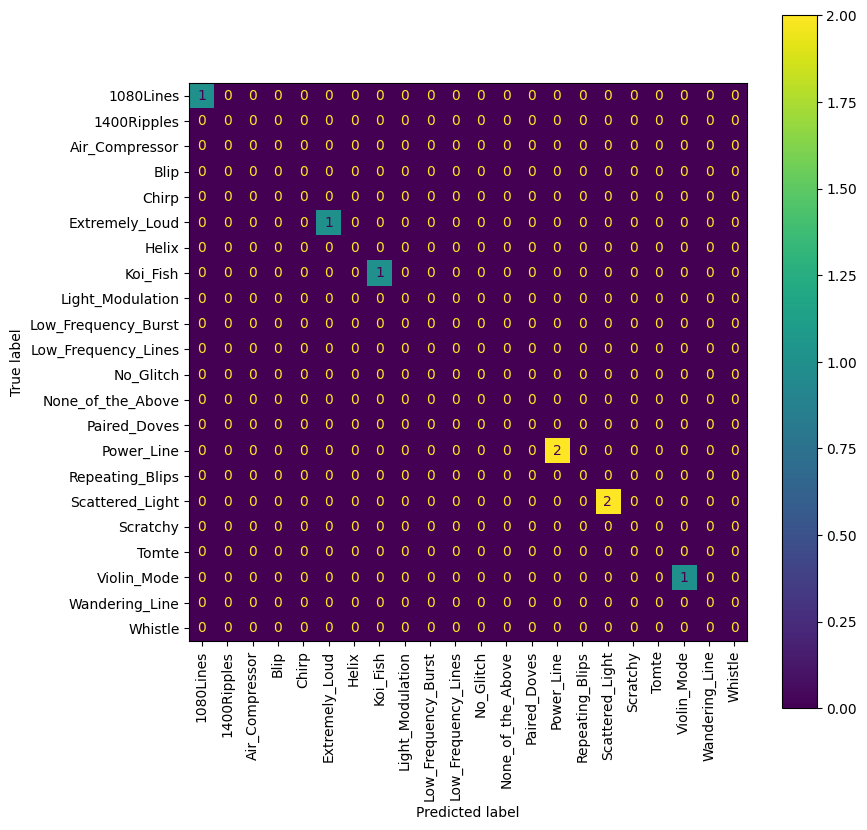

In [31]:
show_confusion(label_indices, label_indices)

# Primary Task
## 1. Train a neural network to classify the Glitches
## 2. Invest some time into optimizing your network’s performance

# Questions
1. How do you measure your network’s performance?
    - What is your reason for this choice?
    - What other good choices are there?
2. What classes stand out and why?
5. Find the Glitch images that your network performs best(worst) with. Explain why this is the case.